In [ ]:
# Install required libraries
!pip install transformers datasets torch --quiet
import numpy as np
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel, get_scheduler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.tensorboard import SummaryWriter


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


##Naive Bayes For Baseline

In [ ]:
#Reading the files
df1 = pd.read_csv("/content/train.csv")
df2 = pd.read_csv("/content/test.csv")
mismatch_df = pd.read_csv("/content/5000-row_Mismatched_Dataset_for_PVI_Filtering.csv") # This is the noisy data that we generated
df2.rename(columns={'intent': 'category'}, inplace=True)
result = pd.concat([df1, df2], ignore_index=True) # We concatanated the dfs for now but in train test split function we have splitted it into train valid test again


In [ ]:
result = pd.concat([mismatch_df, result], ignore_index=True)

In [ ]:
result

,text,category
0,How do I create a personal budget?,balance_not_updated_after_bank_transfer
1,How do I cook pasta perfectly?,transfer_timing
2,Is my account secure from unauthorized access?,exchange_rate
3,Can I get notified for failed transactions?,receiving_money
4,I am unable to verify my identity.,virtual_card_not_working
...,...,...
18078,"If i'm not in the UK, can I still get a card?",country_support
18079,How many countries do you support?,country_support
18080,What countries do you do business in?,country_support
18081,What are the countries you operate in.,country_support


In [ ]:


# Step 1: Load and combine datasets
# Assuming 'result' dataframe is already defined and contains 'text' and 'category'

# Step 2: Preprocess the data
result.dropna(subset=['text', 'category'], inplace=True)  # Drop rows with missing values
X = result['text']  # Features (text data)
y = result['category']  # Target variable

# Convert text to numerical features
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_vectorized = vectorizer.fit_transform(X)

# Step 3: Split the data
# Initial split: 80% train, 20% temp (for validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# Second split: Split temp into 10% validation and 10% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Verify the sizes of the splits
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Step 4: Train the Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train, y_train)



# Step 6: Optionally, evaluate on the validation set
# Evaluate on the validation set
y_pred_val = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred_val)
print("Validation Set Performance:")
print(classification_report(y_val, y_pred_val))
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Evaluate on the test set
y_pred_test = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Set Performance:")
print(classification_report(y_test, y_pred_test))
print(f"Test Accuracy: {test_accuracy:.2f}")



Training set size: 14466
Validation set size: 1808
Test set size: 1809
Validation Set Performance:
                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.76      0.70      0.73        27
                                activate_my_card       0.43      0.67      0.52        24
                                       age_limit       0.50      0.47      0.48        15
                         apple_pay_or_google_pay       0.95      0.76      0.84        25
                                     atm_support       0.15      0.28      0.20        18
                                automatic_top_up       0.50      0.59      0.54        27
         balance_not_updated_after_bank_transfer       0.40      0.54      0.46        26
balance_not_updated_after_cheque_or_cash_deposit       0.63      0.77      0.70        31
                         beneficiary_not_allowed       0.78      0.67      0.72        27


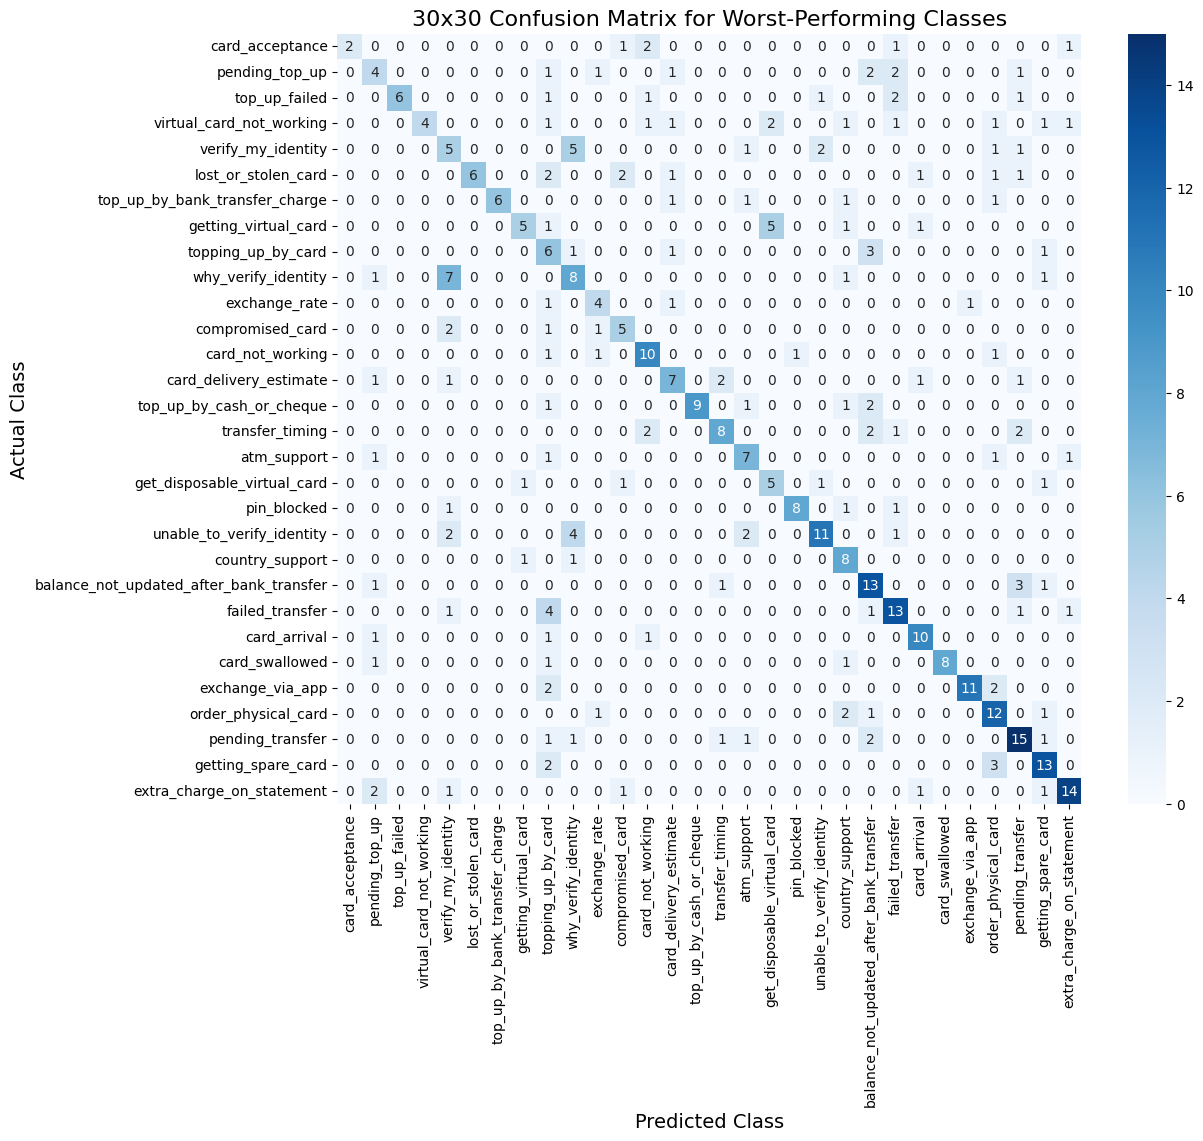

In [ ]:
# Assuming y_test and y_pred are already defined
cm = confusion_matrix(y_test, y_pred_test, labels=np.unique(y_test))
class_names = np.unique(y_test)  # Unique class names

# Calculate per-class accuracy (diagonal values divided by row sums)
accuracy_per_class = cm.diagonal() / cm.sum(axis=1)
accuracy_per_class = np.nan_to_num(accuracy_per_class)  # Handle NaN for classes with no samples

# Identify the indices of the 30 worst-performing classes
worst_classes_indices = np.argsort(accuracy_per_class)[:30]

# Extract the 30x30 sub-matrix
worst_cm = cm[np.ix_(worst_classes_indices, worst_classes_indices)]
worst_class_names = class_names[worst_classes_indices]

# Plot the 30x30 confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(worst_cm, annot=True, fmt='d', cmap='Blues', xticklabels=worst_class_names, yticklabels=worst_class_names)
plt.title('30x30 Confusion Matrix for Worst-Performing Classes', fontsize=16)
plt.xlabel('Predicted Class', fontsize=14)
plt.ylabel('Actual Class', fontsize=14)
plt.show()


#distilBert + Softmax With the Best Parameters Without PVI Filtering


In [ ]:
#Reading the files
df1 = pd.read_csv("/content/train.csv")
df2 = pd.read_csv("/content/test.csv")
mismatch_df = pd.read_csv("/content/5000-row_Mismatched_Dataset_for_PVI_Filtering.csv")  # This is the noisy data that we generated
df2.rename(columns={'intent': 'category'}, inplace=True)
result = pd.concat([df1, df2], ignore_index=True) # We concatanated the dfs for now but in train test split function we have splitted it into train valid test again

In [ ]:
result = pd.concat([mismatch_df, result], ignore_index=True)

In [ ]:
result

,text,category
0,How do I create a personal budget?,balance_not_updated_after_bank_transfer
1,How do I cook pasta perfectly?,transfer_timing
2,Is my account secure from unauthorized access?,exchange_rate
3,Can I get notified for failed transactions?,receiving_money
4,I am unable to verify my identity.,virtual_card_not_working
...,...,...
18078,"If i'm not in the UK, can I still get a card?",country_support
18079,How many countries do you support?,country_support
18080,What countries do you do business in?,country_support
18081,What are the countries you operate in.,country_support


In [ ]:
# Encode labels
label_encoder = LabelEncoder()
result['label'] = label_encoder.fit_transform(result['category'])

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    result['text'], result['label'], test_size=0.2, random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)


# Load pre-trained DistilBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
distilbert = AutoModel.from_pretrained("distilbert-base-uncased")

# Ensure parameters are trainable
for param in distilbert.parameters():
    param.requires_grad = True

# Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.encodings = [
            tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
            for text in tqdm(texts, desc="Tokenizing texts")
        ]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.encodings[idx]
        label = self.labels.iloc[idx]
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Initialize datasets and dataloaders
train_dataset = TextDataset(train_texts, train_labels)
val_dataset = TextDataset(val_texts, val_labels)
test_dataset = TextDataset(test_texts, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)



# Define model with DistilBERT
class SoftmaxClassifier(nn.Module):
    def __init__(self, distilbert, num_classes):
        super(SoftmaxClassifier, self).__init__()
        self.distilbert = distilbert
        self.classifier = nn.Sequential(
            nn.Linear(distilbert.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = torch.mean(outputs.last_hidden_state, dim=1)  # Mean Pooling
        logits = self.classifier(pooled_output)
        return logits


# Initialize model
num_classes = len(label_encoder.classes_)
model = SoftmaxClassifier(distilbert, num_classes)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Define optimizer, scheduler, and loss
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 5
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Tokenizing texts: 100%|██████████| 1809/1809 [00:00<00:00, 4546.51it/s]


In [ ]:
################################## Training loop ################################## This model that has the best parameters.
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        logits = model(batch["input_ids"], batch["attention_mask"])
        loss = criterion(logits, batch["label"])
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_loss:.4f}")

    model.eval()
    val_loss = 0
    val_labels_list, val_preds_list = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = model(batch["input_ids"], batch["attention_mask"])
            loss = criterion(logits, batch["label"])
            val_loss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            val_labels_list.extend(batch["label"].cpu().numpy())
            val_preds_list.extend(predictions.cpu().numpy())
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_labels_list, val_preds_list)
    val_f1 = f1_score(val_labels_list, val_preds_list, average="weighted")
    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1-score: {val_f1:.4f}")

################################## Test Evaluation ##################################
model.eval()
test_labels_list, test_preds_list = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        logits = model(batch["input_ids"], batch["attention_mask"])
        predictions = torch.argmax(logits, dim=1)
        test_labels_list.extend(batch["label"].cpu().numpy())
        test_preds_list.extend(predictions.cpu().numpy())

test_accuracy = accuracy_score(test_labels_list, test_preds_list)
test_f1 = f1_score(test_labels_list, test_preds_list, average="weighted")
print(f"Test Accuracy: {test_accuracy:.4f}, F1-score: {test_f1:.4f}")

Epoch 1, Training Loss: 2.6175
Validation Loss: 1.6613, Accuracy: 0.6327, F1-score: 0.6648
Epoch 2, Training Loss: 1.4921
Validation Loss: 1.4700, Accuracy: 0.6648, F1-score: 0.6850
Epoch 3, Training Loss: 1.3014
Validation Loss: 1.4479, Accuracy: 0.6720, F1-score: 0.6825
Epoch 4, Training Loss: 1.1971
Validation Loss: 1.4641, Accuracy: 0.6742, F1-score: 0.6803
Epoch 5, Training Loss: 1.1281
Validation Loss: 1.4781, Accuracy: 0.6720, F1-score: 0.6767
Test Accuracy: 0.6672, F1-score: 0.6732


In [ ]:


conf_matrix = confusion_matrix(test_labels_list, test_preds_list)

# Extract true positive counts (diagonal of the confusion matrix)
true_positive_counts = np.diag(conf_matrix)

# Total samples for each class in the test set
total_true_counts = np.sum(conf_matrix, axis=1)

# Calculate prediction accuracy per class
class_accuracy_per_class = true_positive_counts / total_true_counts

# Find classes with low prediction accuracy
threshold = 0.65  # Example: accuracy below 65%
poorly_predicted_classes = np.where(class_accuracy_per_class < threshold)[0]

# Get class names for poorly predicted classes
poorly_predicted_class_names = label_encoder.classes_[poorly_predicted_classes]

print(f"Classes with prediction accuracy below {threshold*100}%:")
for class_name, accuracy in zip(poorly_predicted_class_names, class_accuracy_per_class[poorly_predicted_classes]):
    print(f"{class_name}: {accuracy:.2f}")

Classes with prediction accuracy below 65.0%:
age_limit: 0.57
apple_pay_or_google_pay: 0.58
atm_support: 0.65
balance_not_updated_after_bank_transfer: 0.59
card_arrival: 0.45
card_delivery_estimate: 0.56
card_linking: 0.62
card_not_working: 0.54
card_payment_wrong_exchange_rate: 0.62
card_swallowed: 0.53
cash_withdrawal_not_recognised: 0.62
compromised_card: 0.43
country_support: 0.61
declined_transfer: 0.53
exchange_via_app: 0.52
extra_charge_on_statement: 0.61
failed_transfer: 0.62
get_disposable_virtual_card: 0.50
get_physical_card: 0.57
getting_virtual_card: 0.65
lost_or_stolen_card: 0.40
lost_or_stolen_phone: 0.64
pending_top_up: 0.45
pending_transfer: 0.58
pin_blocked: 0.63
top_up_by_bank_transfer_charge: 0.52
top_up_limits: 0.62
topping_up_by_card: 0.55
transfer_into_account: 0.62
transfer_timing: 0.55
verify_my_identity: 0.50
verify_top_up: 0.62
virtual_card_not_working: 0.40
why_verify_identity: 0.62


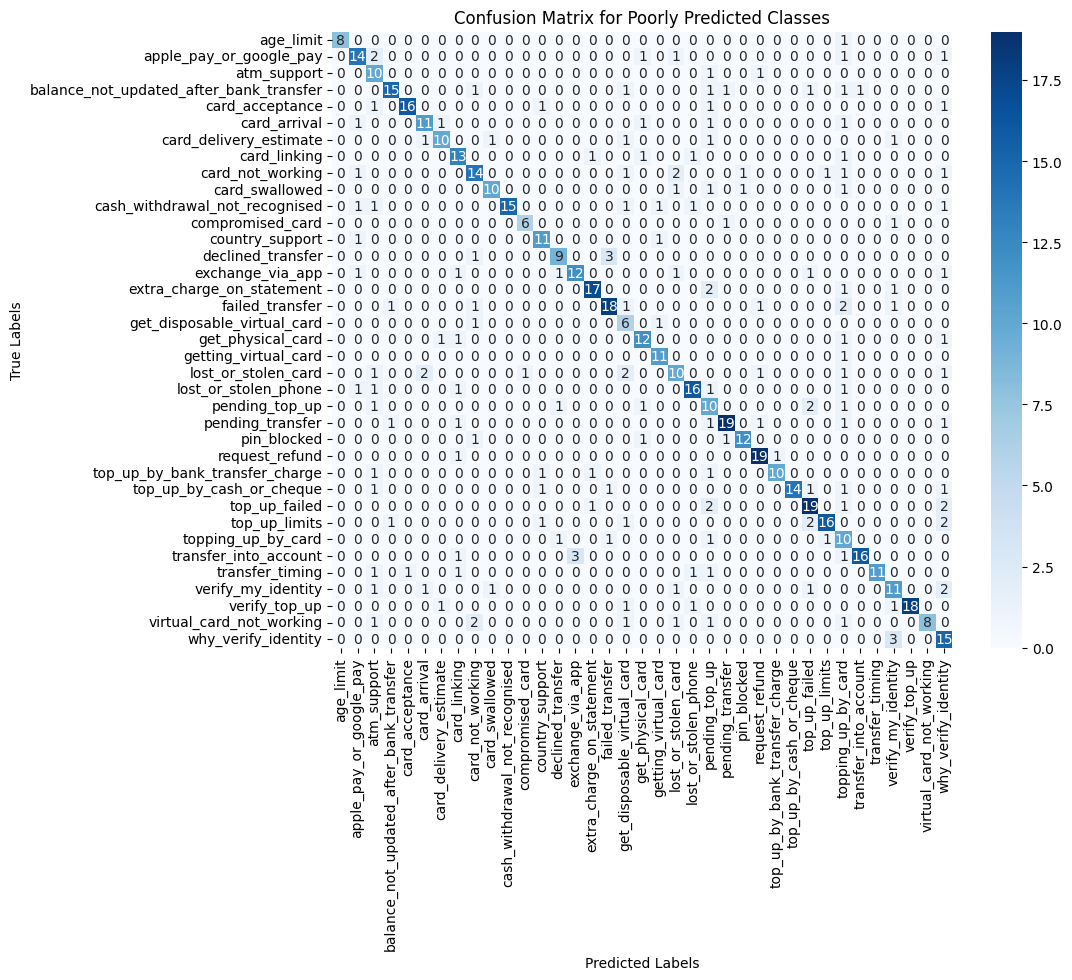

In [ ]:
# Filter confusion matrix for poorly predicted classes
conf_matrix_poorly_predicted = conf_matrix[poorly_predicted_classes][:, poorly_predicted_classes]

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_poorly_predicted, annot=True, fmt='d', cmap='Blues',
            xticklabels=poorly_predicted_class_names, yticklabels=poorly_predicted_class_names)
plt.title('Confusion Matrix for Poorly Predicted Classes')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
# Analyze misclassifications for each poorly predicted class
for class_id in poorly_predicted_classes:
    true_label = label_encoder.classes_[class_id]
    predicted_counts = conf_matrix[class_id]

    # Sort by misclassification count
    misclassified = [(label_encoder.classes_[i], count)
                     for i, count in enumerate(predicted_counts) if i != class_id and count > 0]
    misclassified = sorted(misclassified, key=lambda x: x[1], reverse=True)

    print(f"\nClass '{true_label}' is most often confused with:")
    for pred_label, count in misclassified:
        print(f"  - {pred_label}: {count} times")



Class 'age_limit' is most often confused with:
  - verify_source_of_funds: 2 times
  - balance_not_updated_after_cheque_or_cash_deposit: 1 times
  - contactless_not_working: 1 times
  - terminate_account: 1 times
  - topping_up_by_card: 1 times

Class 'apple_pay_or_google_pay' is most often confused with:
  - atm_support: 2 times
  - beneficiary_not_allowed: 1 times
  - contactless_not_working: 1 times
  - get_physical_card: 1 times
  - lost_or_stolen_card: 1 times
  - pending_cash_withdrawal: 1 times
  - receiving_money: 1 times
  - topping_up_by_card: 1 times
  - why_verify_identity: 1 times

Class 'atm_support' is most often confused with:
  - card_payment_wrong_exchange_rate: 1 times
  - change_pin: 1 times
  - direct_debit_payment_not_recognised: 1 times
  - passcode_forgotten: 1 times
  - pending_top_up: 1 times
  - request_refund: 1 times
  - transfer_fee_charged: 1 times

Class 'balance_not_updated_after_bank_transfer' is most often confused with:
  - edit_personal_details: 2 

In [ ]:
# Find indices of misclassified samples
misclassified_indices = [i for i, (true, pred) in enumerate(zip(test_labels_list, test_preds_list)) if true != pred]

# Display misclassified examples
print("Misclassified Examples:")
for idx in misclassified_indices[:10]:  # Show first 10 examples
    print(f"True Label: {label_encoder.classes_[test_labels_list[idx]]}, Predicted: {label_encoder.classes_[test_preds_list[idx]]}")


Misclassified Examples:
True Label: why_verify_identity, Predicted: reverted_card_payment?
True Label: passcode_forgotten, Predicted: apple_pay_or_google_pay
True Label: lost_or_stolen_phone, Predicted: top_up_reverted
True Label: top_up_failed, Predicted: why_verify_identity
True Label: supported_cards_and_currencies, Predicted: top_up_reverted
True Label: top_up_by_bank_transfer_charge, Predicted: top_up_by_card_charge
True Label: exchange_charge, Predicted: card_payment_fee_charged
True Label: topping_up_by_card, Predicted: disposable_card_limits
True Label: transfer_fee_charged, Predicted: top_up_failed
True Label: failed_transfer, Predicted: topping_up_by_card


# distilBert + Softmax With the Best Parameters. (PVI Filtering is applied)

In [ ]:
#Reading the files
df1 = pd.read_csv("/content/train.csv")
df2 = pd.read_csv("/content/test.csv")
mismatch_df = pd.read_csv("/content/5000-row_Mismatched_Dataset_for_PVI_Filtering.csv")  # This is the noisy data that we generated
df2.rename(columns={'intent': 'category'}, inplace=True)
result = pd.concat([df1, df2], ignore_index=True) # We concatanated the dfs for now but in train test split function we have splitted it into train valid test again


In [ ]:
# Encode labels
label_encoder = LabelEncoder()
result['label'] = label_encoder.fit_transform(result['category'])
mismatch_df['label'] = label_encoder.fit_transform(mismatch_df['category'])

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    result['text'], result['label'], test_size=0.2, random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)


# Load pre-trained DistilBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
distilbert = AutoModel.from_pretrained("distilbert-base-uncased")

# Ensure parameters are trainable
for param in distilbert.parameters():
    param.requires_grad = True

# Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.encodings = [
            tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
            for text in tqdm(texts, desc="Tokenizing texts")
        ]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.encodings[idx]
        label = self.labels.iloc[idx]
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Initialize datasets and dataloaders
train_dataset = TextDataset(train_texts, train_labels)
val_dataset = TextDataset(val_texts, val_labels)
test_dataset = TextDataset(test_texts, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)



# Define model with DistilBERT
class SoftmaxClassifier(nn.Module):
    def __init__(self, distilbert, num_classes):
        super(SoftmaxClassifier, self).__init__()
        self.distilbert = distilbert
        self.classifier = nn.Sequential(
            nn.Linear(distilbert.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = torch.mean(outputs.last_hidden_state, dim=1)  # Mean Pooling
        logits = self.classifier(pooled_output)
        return logits


# Initialize model
num_classes = len(label_encoder.classes_)
model = SoftmaxClassifier(distilbert, num_classes)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Define optimizer, scheduler, and loss
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 5
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)
criterion = nn.CrossEntropyLoss()

Tokenizing texts: 100%|██████████| 1309/1309 [00:00<00:00, 2623.94it/s]


Fine Tuning the distilBert Before PVI filtering

In [ ]:
# Training loop
num_epochs = 5
writer = SummaryWriter()  # For logging (optional)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        lr_scheduler.step()



# Validation loop (optional, but recommended)
model.eval()
val_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)
        val_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)




Training Epoch 5/5: 100%|██████████| 655/655 [01:53<00:00,  5.77it/s]


In [ ]:
combined_df = pd.concat([mismatch_df, result], ignore_index=True)

In [ ]:
combined_df

,text,category,label
0,How do I create a personal budget?,balance_not_updated_after_bank_transfer,6
1,How do I cook pasta perfectly?,transfer_timing,67
2,Is my account secure from unauthorized access?,exchange_rate,33
3,Can I get notified for failed transactions?,receiving_money,51
4,I am unable to verify my identity.,virtual_card_not_working,72
...,...,...,...
18078,"If i'm not in the UK, can I still get a card?",country_support,25
18079,How many countries do you support?,country_support,25
18080,What countries do you do business in?,country_support,25
18081,What are the countries you operate in.,country_support,25


PVI Filtering

In [ ]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the selected device

# Function to calculate accuracy
def calculate_accuracy(text, label):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)  # Move inputs to the device
    label_tensor = torch.tensor(label).to(device)  # Move label to the device
    with torch.no_grad():
        logits = model(inputs["input_ids"], inputs["attention_mask"])  # Use model output directly
    probs = torch.nn.functional.softmax(logits, dim=-1)
    accuracy = probs[0, label_tensor].item()  # Probability of the correct class
    return accuracy

# Evaluate instances
threshold = 4.5
chosen_instances = []
scores = []

for idx, row in combined_df.iterrows():  # Iterate over your sampled DataFrame
    text, label = row['text'], row['label']

    # Calculate accuracy for an empty string
    empty_accuracy = calculate_accuracy("", label)

    # Calculate accuracy for the actual text
    text_accuracy = calculate_accuracy(text, label)

    # Compute log2 values and their sum
    score = -torch.log2(torch.tensor(empty_accuracy)) + torch.log2(torch.tensor(text_accuracy))
    #print("score: " , score.item())
    scores.append(score.item())

    # Compare with threshold and add to chosen instances if the condition is met
    if score.item() > threshold:
        chosen_instances.append(row)

# Create a DataFrame of chosen instances
chosen_df = pd.DataFrame(chosen_instances)

# Calculate mean and standard deviation of scores
mean_score = np.mean(scores)
std_dev_score = np.std(scores)

# Calculate new threshold
new_threshold = mean_score - std_dev_score

print(chosen_df.head())


                                                  text  \
29            What are the rules for adopting a child?   
154                     What are the basics of sewing?   
205  The stock market is highly unpredictable these...   
407             How do I set up a home theater system?   
603                    What is the latest sports news?   

                        category  label  
29                     age_limit      2  
154                   change_pin     22  
205                exchange_rate     33  
407  get_disposable_virtual_card     38  
603                exchange_rate     33  


In [ ]:
chosen_df #PVI filtered df (exctracted the noisy data)

,text,category,label
29,What are the rules for adopting a child?,age_limit,2
154,What are the basics of sewing?,change_pin,22
205,The stock market is highly unpredictable these...,exchange_rate,33
407,How do I set up a home theater system?,get_disposable_virtual_card,38
603,What is the latest sports news?,exchange_rate,33
...,...,...,...
18078,"If i'm not in the UK, can I still get a card?",country_support,25
18079,How many countries do you support?,country_support,25
18080,What countries do you do business in?,country_support,25
18081,What are the countries you operate in.,country_support,25


In [ ]:
# Find the intersection of rows between chosen_df and mismatch_df based on common columns ('text' and 'label')
intersect_df = pd.merge(chosen_df, mismatch_df, on=['text', 'label'], how='inner')

# Get the number of rows in the intersection
num_intersection = len(intersect_df)

print(f"Number of rows that intersect in chosen_df and mismatch_df: {num_intersection}")

Number of rows that intersect in chosen_df and mismatch_df: 19


In [ ]:
# So our PVI filtering managed to eliminate 4981 mismatched row out of 5000

In [ ]:
# Find the intersection of rows between chosen_df and mismatch_df based on common columns ('text' and 'label')
intersect_df = pd.merge(chosen_df, result, on=['text', 'label'], how='inner')

# Get the number of rows in the intersection
num_intersection = len(intersect_df)

print(f"Number of rows that intersect in chosen_df and result: {num_intersection}")

Number of rows that intersect in chosen_df and result: 12886


In [ ]:
print(f"Number of rows that we have lost in original data {result.shape[0] - num_intersection}")

Number of rows that we have lost in original data 197


In [ ]:
chosen_df

,text,category,label
29,What are the rules for adopting a child?,age_limit,2
154,What are the basics of sewing?,change_pin,22
205,The stock market is highly unpredictable these...,exchange_rate,33
407,How do I set up a home theater system?,get_disposable_virtual_card,38
603,What is the latest sports news?,exchange_rate,33
...,...,...,...
18078,"If i'm not in the UK, can I still get a card?",country_support,25
18079,How many countries do you support?,country_support,25
18080,What countries do you do business in?,country_support,25
18081,What are the countries you operate in.,country_support,25


In [ ]:
result = chosen_df.drop(columns=['label'])

In [ ]:
result

,text,category
29,What are the rules for adopting a child?,age_limit
154,What are the basics of sewing?,change_pin
205,The stock market is highly unpredictable these...,exchange_rate
407,How do I set up a home theater system?,get_disposable_virtual_card
603,What is the latest sports news?,exchange_rate
...,...,...
18078,"If i'm not in the UK, can I still get a card?",country_support
18079,How many countries do you support?,country_support
18080,What countries do you do business in?,country_support
18081,What are the countries you operate in.,country_support


In [ ]:
# Encode labels
label_encoder = LabelEncoder()
result['label'] = label_encoder.fit_transform(result['category'])

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    result['text'], result['label'], test_size=0.2, random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)


# Load pre-trained DistilBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
distilbert = AutoModel.from_pretrained("distilbert-base-uncased")

# Ensure parameters are trainable
for param in distilbert.parameters():
    param.requires_grad = True

# Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.encodings = [
            tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
            for text in tqdm(texts, desc="Tokenizing texts")
        ]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.encodings[idx]
        label = self.labels.iloc[idx]
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Initialize datasets and dataloaders
train_dataset = TextDataset(train_texts, train_labels)
val_dataset = TextDataset(val_texts, val_labels)
test_dataset = TextDataset(test_texts, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)



# Define model with DistilBERT
class SoftmaxClassifier(nn.Module):
    def __init__(self, distilbert, num_classes):
        super(SoftmaxClassifier, self).__init__()
        self.distilbert = distilbert
        self.classifier = nn.Sequential(
            nn.Linear(distilbert.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = torch.mean(outputs.last_hidden_state, dim=1)  # Mean Pooling
        logits = self.classifier(pooled_output)
        return logits


# Initialize model
num_classes = len(label_encoder.classes_)
model = SoftmaxClassifier(distilbert, num_classes)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Define optimizer, scheduler, and loss
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
num_training_steps = len(train_loader) * 5
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)
criterion = nn.CrossEntropyLoss()

Tokenizing texts: 100%|██████████| 1291/1291 [00:00<00:00, 4156.40it/s]


In [ ]:
################################## Training loop ################################## This model that has the best parameters.
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        logits = model(batch["input_ids"], batch["attention_mask"])
        loss = criterion(logits, batch["label"])
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_loss:.4f}")

    model.eval()
    val_loss = 0
    val_labels_list, val_preds_list = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = model(batch["input_ids"], batch["attention_mask"])
            loss = criterion(logits, batch["label"])
            val_loss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            val_labels_list.extend(batch["label"].cpu().numpy())
            val_preds_list.extend(predictions.cpu().numpy())
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_labels_list, val_preds_list)
    val_f1 = f1_score(val_labels_list, val_preds_list, average="weighted")
    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1-score: {val_f1:.4f}")

################################## Test Evaluation ##################################
model.eval()
test_labels_list, test_preds_list = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        logits = model(batch["input_ids"], batch["attention_mask"])
        predictions = torch.argmax(logits, dim=1)
        test_labels_list.extend(batch["label"].cpu().numpy())
        test_preds_list.extend(predictions.cpu().numpy())

test_accuracy = accuracy_score(test_labels_list, test_preds_list)
test_f1 = f1_score(test_labels_list, test_preds_list, average="weighted")
print(f"Test Accuracy: {test_accuracy:.4f}, F1-score: {test_f1:.4f}")


Epoch 1, Training Loss: 1.8341
Validation Loss: 0.5060, Accuracy: 0.8969, F1-score: 0.8961
Epoch 2, Training Loss: 0.3363
Validation Loss: 0.2858, Accuracy: 0.9310, F1-score: 0.9308
Epoch 3, Training Loss: 0.1303
Validation Loss: 0.2761, Accuracy: 0.9240, F1-score: 0.9231
Validation Loss: 0.2304, Accuracy: 0.9434, F1-score: 0.9436
Epoch 5, Training Loss: 0.0370
Validation Loss: 0.2374, Accuracy: 0.9434, F1-score: 0.9433
Test Accuracy: 0.9388, F1-score: 0.9387


In [ ]:

conf_matrix = confusion_matrix(test_labels_list, test_preds_list)

# Extract true positive counts (diagonal of the confusion matrix)
true_positive_counts = np.diag(conf_matrix)

# Total samples for each class in the test set
total_true_counts = np.sum(conf_matrix, axis=1)

# Calculate prediction accuracy per class
class_accuracy_per_class = true_positive_counts / total_true_counts

# Find classes with low prediction accuracy
threshold = 0.93  # Example: accuracy below 50%
poorly_predicted_classes = np.where(class_accuracy_per_class < threshold)[0]

# Get class names for poorly predicted classes
poorly_predicted_class_names = label_encoder.classes_[poorly_predicted_classes]

print(f"Classes with prediction accuracy below {threshold*100}%:")
for class_name, accuracy in zip(poorly_predicted_class_names, class_accuracy_per_class[poorly_predicted_classes]):
    print(f"{class_name}: {accuracy:.2f}")

Classes with prediction accuracy below 93.0%:
age_limit: 0.92
atm_support: 0.92
balance_not_updated_after_bank_transfer: 0.89
beneficiary_not_allowed: 0.80
card_acceptance: 0.92
card_linking: 0.88
card_payment_fee_charged: 0.90
card_payment_not_recognised: 0.86
card_payment_wrong_exchange_rate: 0.91
card_swallowed: 0.80
cash_withdrawal_charge: 0.89
compromised_card: 0.85
declined_transfer: 0.88
direct_debit_payment_not_recognised: 0.85
exchange_via_app: 0.92
failed_transfer: 0.86
get_disposable_virtual_card: 0.92
getting_virtual_card: 0.90
lost_or_stolen_card: 0.80
pending_card_payment: 0.92
pending_transfer: 0.89
pin_blocked: 0.83
receiving_money: 0.90
request_refund: 0.91
supported_cards_and_currencies: 0.92
top_up_by_bank_transfer_charge: 0.82
top_up_by_cash_or_cheque: 0.92
top_up_reverted: 0.80
transfer_fee_charged: 0.84
transfer_not_received_by_recipient: 0.82
verify_my_identity: 0.90
virtual_card_not_working: 0.90
wrong_amount_of_cash_received: 0.93


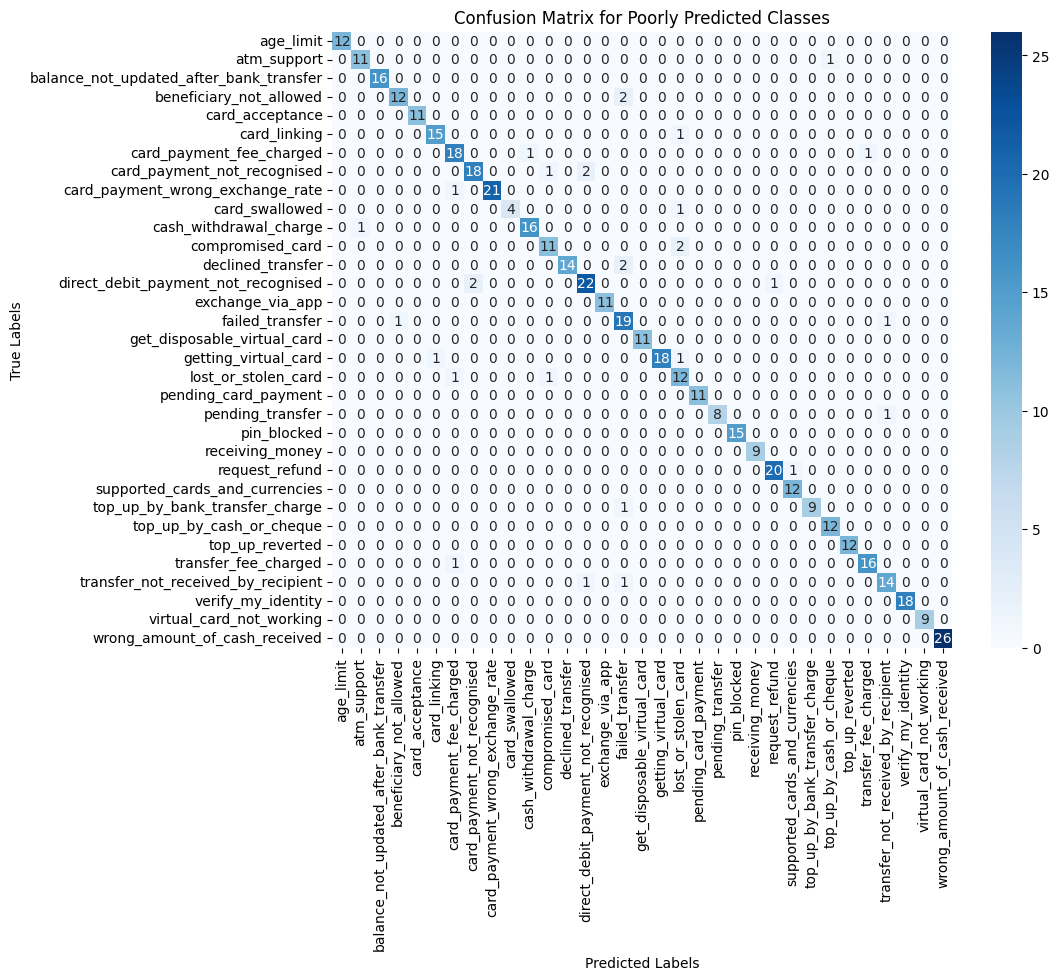

In [ ]:
# Filter confusion matrix for poorly predicted classes
conf_matrix_poorly_predicted = conf_matrix[poorly_predicted_classes][:, poorly_predicted_classes]

# Create heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_poorly_predicted, annot=True, fmt='d', cmap='Blues',
            xticklabels=poorly_predicted_class_names, yticklabels=poorly_predicted_class_names)
plt.title('Confusion Matrix for Poorly Predicted Classes')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
# Analyze misclassifications for each poorly predicted class
for class_id in poorly_predicted_classes:
    true_label = label_encoder.classes_[class_id]
    predicted_counts = conf_matrix[class_id]

    # Sort by misclassification count
    misclassified = [(label_encoder.classes_[i], count)
                     for i, count in enumerate(predicted_counts) if i != class_id and count > 0]
    misclassified = sorted(misclassified, key=lambda x: x[1], reverse=True)

    print(f"\nClass '{true_label}' is most often confused with:")
    for pred_label, count in misclassified:
        print(f"  - {pred_label}: {count} times")



Class 'age_limit' is most often confused with:
  - getting_spare_card: 1 times

Class 'atm_support' is most often confused with:
  - top_up_by_cash_or_cheque: 1 times

Class 'balance_not_updated_after_bank_transfer' is most often confused with:
  - transfer_into_account: 1 times
  - transfer_timing: 1 times

Class 'beneficiary_not_allowed' is most often confused with:
  - failed_transfer: 2 times
  - declined_card_payment: 1 times

Class 'card_acceptance' is most often confused with:
  - order_physical_card: 1 times

Class 'card_linking' is most often confused with:
  - lost_or_stolen_card: 1 times
  - order_physical_card: 1 times

Class 'card_payment_fee_charged' is most often confused with:
  - cash_withdrawal_charge: 1 times
  - transfer_fee_charged: 1 times

Class 'card_payment_not_recognised' is most often confused with:
  - direct_debit_payment_not_recognised: 2 times
  - compromised_card: 1 times

Class 'card_payment_wrong_exchange_rate' is most often confused with:
  - card_pa

In [ ]:
# Find indices of misclassified samples
misclassified_indices = [i for i, (true, pred) in enumerate(zip(test_labels_list, test_preds_list)) if true != pred]

# Display misclassified examples
print("Misclassified Examples:")
for idx in misclassified_indices[:10]:  # Show first 10 examples
    print(f"True Label: {label_encoder.classes_[test_labels_list[idx]]}, Predicted: {label_encoder.classes_[test_preds_list[idx]]}")


Misclassified Examples:
True Label: card_arrival, Predicted: card_delivery_estimate
True Label: transfer_fee_charged, Predicted: card_payment_fee_charged
True Label: pending_transfer, Predicted: transfer_not_received_by_recipient
True Label: card_delivery_estimate, Predicted: card_arrival
True Label: pin_blocked, Predicted: change_pin
True Label: beneficiary_not_allowed, Predicted: failed_transfer
True Label: card_swallowed, Predicted: lost_or_stolen_card
True Label: wrong_amount_of_cash_received, Predicted: declined_cash_withdrawal
True Label: card_payment_fee_charged, Predicted: cash_withdrawal_charge
True Label: declined_transfer, Predicted: failed_transfer


This is the experimental code that is used for finding best parameters for distilBert + Softmax and we have used the parameters for both models(distilBert + Softmax with PVI Filtering, distilBert + Softmax without PVI Filtering) it took us approximately 3 hours to run in 2 different accounts. So this code is just for showing the work that we have done.

Activation Functions Tested: ReLU, LeakyReLU, Sigmoid
Loss Functions Tested: CrossEntropyLoss
Evaluation Metrics: Validation Loss, Accuracy, F1-score, Test Accuracy, and Test F1-score.


###Experimental Code
#### Model Architecture: DistilBERT-based classifier.
- **Parameters**:
- **Dropout**: 0.1,0.2,0.3,0.4,0.5
- **Learning Rate**: 1e-05,3e-5,2e-5,1e-4,5e-05
- **Epochs**: 5,6,7,8
- **Activation Functions Tested**: ReLU, LeakyReLU, Sigmoid,Tanh
- **Loss Functions Tested**: CrossEntropyLoss
- **Evaluation Metrics**: Validation Loss, Accuracy, F1-score, Test Accuracy, and Test F1-score.

In [ ]:
label_encoder = LabelEncoder()
result['label'] = label_encoder.fit_transform(result['category'])

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    result['text'], result['label'], test_size=0.2, random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)


# Load pre-trained DistilBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
distilbert = AutoModel.from_pretrained("distilbert-base-uncased")

# Ensure parameters are trainable
for param in distilbert.parameters():
    param.requires_grad = True

# Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.encodings = [
            tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
            for text in tqdm(texts, desc="Tokenizing texts")
        ]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.encodings[idx]
        label = self.labels.iloc[idx]
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Initialize datasets and dataloaders
train_dataset = TextDataset(train_texts, train_labels)
val_dataset = TextDataset(val_texts, val_labels)
test_dataset = TextDataset(test_texts, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Define a SoftmaxClassifier with various activation functions
class SoftmaxClassifier(nn.Module):
    def __init__(self, pretrained_model, num_classes, dropout=0.1, activation_fn=nn.ReLU()):
        super(SoftmaxClassifier, self).__init__()
        self.distilbert = pretrained_model
        self.dropout = nn.Dropout(dropout)
        self.activation_fn = activation_fn
        self.fc = nn.Linear(self.distilbert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        x = self.distilbert(input_ids, attention_mask=attention_mask).last_hidden_state[:, 0]
        x = self.dropout(x)
        x = self.activation_fn(x)  # Apply chosen activation function
        x = self.fc(x)
        return x



# Initialize variables to track the best experiment
best_accuracy = 0.0
best_experiment = None


# Define experiments with different activation functions
experiments = [
    {"dropout": 0.1, "lr": 5e-5, "epochs": 5, "activation_fn": nn.ReLU(), "loss_fn": nn.CrossEntropyLoss()},
    {"dropout": 0.1, "lr": 3e-5, "epochs": 5, "activation_fn": nn.LeakyReLU(), "loss_fn": nn.CrossEntropyLoss()},
    {"dropout": 0.2, "lr": 3e-5, "epochs": 5, "activation_fn": nn.Sigmoid(), "loss_fn": nn.CrossEntropyLoss()},
    {"dropout": 0.2, "lr": 5e-5, "epochs": 5, "activation_fn": nn.Tanh(), "loss_fn": nn.CrossEntropyLoss()},
    {"dropout": 0.4, "lr": 5e-5, "epochs": 5, "activation_fn": nn.ReLU(), "loss_fn": nn.CrossEntropyLoss()},

    {"dropout": 0.1, "lr": 5e-5, "epochs": 8, "activation_fn": nn.ReLU(), "loss_fn": nn.CrossEntropyLoss()},
    {"dropout": 0.1, "lr": 5e-5, "epochs": 5, "activation_fn": nn.Sigmoid(), "loss_fn": nn.CrossEntropyLoss()},
    {"dropout": 0.2, "lr": 5e-5, "epochs": 8, "activation_fn": nn.ReLU(), "loss_fn": nn.CrossEntropyLoss()},
    {"dropout": 0.2, "lr": 3e-5, "epochs": 8, "activation_fn": nn.Tanh(), "loss_fn": nn.CrossEntropyLoss()},
    {"dropout": 0.3, "lr": 3e-5, "epochs": 8, "activation_fn": nn.LeakyReLU(), "loss_fn": nn.CrossEntropyLoss()},

    {"dropout": 0.4, "lr": 3e-5, "epochs": 8, "activation_fn": nn.ReLU(), "loss_fn": nn.CrossEntropyLoss()},
    {"dropout": 0.4, "lr": 5e-5, "epochs": 8, "activation_fn": nn.LeakyReLU(), "loss_fn": nn.CrossEntropyLoss()},

    # Additional configurations
    {"dropout": 0.1, "lr": 1e-4, "epochs": 6, "activation_fn": nn.ReLU(), "loss_fn": nn.CrossEntropyLoss()},
    {"dropout": 0.2, "lr": 2e-5, "epochs": 7, "activation_fn": nn.Tanh(), "loss_fn": nn.CrossEntropyLoss()},
    {"dropout": 0.3, "lr": 1e-4, "epochs": 7, "activation_fn": nn.LeakyReLU(), "loss_fn": nn.CrossEntropyLoss()},
    {"dropout": 0.4, "lr": 1e-5, "epochs": 6, "activation_fn": nn.Sigmoid(), "loss_fn": nn.CrossEntropyLoss()},
    {"dropout": 0.5, "lr": 3e-5, "epochs": 8, "activation_fn": nn.ReLU(), "loss_fn": nn.CrossEntropyLoss()},
]

num_classes = len(label_encoder.classes_)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Experiment loop
for config in experiments:
    print(f"Running experiment with dropout={config['dropout']}, lr={config['lr']}, "
          f"epochs={config['epochs']}, activation_fn={config['activation_fn'].__class__.__name__}, "
          f"loss_fn={config['loss_fn'].__class__.__name__}")

    # Initialize model with specified dropout and activation function
    model = SoftmaxClassifier(distilbert, num_classes, config['dropout'], config['activation_fn']).to(device)

    # Define optimizer, scheduler, and loss function
    optimizer = optim.AdamW(model.parameters(), lr=config['lr'])
    num_training_steps = len(train_loader) * config['epochs']
    lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
    criterion = config["loss_fn"]

    # Training Loop
    for epoch in range(config["epochs"]):
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()
            logits = model(batch["input_ids"], batch["attention_mask"])
            loss = criterion(logits, batch["label"])
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}, Training Loss: {avg_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0
        val_labels_list, val_preds_list = [], []
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                logits = model(batch["input_ids"], batch["attention_mask"])
                loss = criterion(logits, batch["label"])
                val_loss += loss.item()
                predictions = torch.argmax(logits, dim=1)
                val_labels_list.extend(batch["label"].cpu().numpy())
                val_preds_list.extend(predictions.cpu().numpy())
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = accuracy_score(val_labels_list, val_preds_list)
        val_f1 = f1_score(val_labels_list, val_preds_list, average="weighted")
        print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1-score: {val_f1:.4f}")

    # Test Evaluation
    model.eval()
    test_labels_list, test_preds_list = [], []
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = model(batch["input_ids"], batch["attention_mask"])
            predictions = torch.argmax(logits, dim=1)
            test_labels_list.extend(batch["label"].cpu().numpy())
            test_preds_list.extend(predictions.cpu().numpy())

    test_accuracy = accuracy_score(test_labels_list, test_preds_list)
    test_f1 = f1_score(test_labels_list, test_preds_list, average="weighted")
    print(f"Test Accuracy: {test_accuracy:.4f}, F1-score: {test_f1:.4f}")

    # Check for best accuracy
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_experiment = config


# Report the best configuration
print("\nBest Experiment Configuration:")
print(f"Dropout: {best_experiment['dropout']}, LR: {best_experiment['lr']}, Epochs: {best_experiment['epochs']}, "
      f"ActivationFn: {best_experiment['activation_fn'].__class__.__name__}, LossFn: {best_experiment['loss_fn'].__class__.__name__}")
print(f"Test Accuracy: {best_accuracy:.4f}")


- **Best Parameters After The Testing**:
- **Dropout**: 0.1
- **Learning Rate**: 1e-05
- **Epochs**: 5
- **Activation Functions Tested**: ReLU
- **Loss Functions Tested**: CrossEntropyLoss
- **Evaluation Metrics**: Validation Loss, Accuracy, F1-score, Test Accuracy, and Test F1-score.

#Report
##Summary of Results
###Performance Metrics for Naive Bayes Classifier:
- Validation Accuracy: 56%
- Validation F1-score: 56%
- Test Accuracy: 56%
- Test F1-score: 56%

### Best Experiment:
- Configuration:
- Dropout: 0.1
- Learning Rate: 5e-05
- Activation Function: ReLU
- Loss Function: CrossEntropyLoss
###Performance Metrics for distilBert + Softmax With the Best Parameters. (PVI Filtering is not applied):
- Validation Accuracy: 67.81%
- Validation F1-score: 68.87%
- Test Accuracy: 66.50%
- Test F1-score: 67.43%

###Performance Metrics for distilBert + Softmax With the Best Parameters. (PVI Filtering is applied):
- Validation Accuracy: 94.10%
- Validation F1-score: 94.10%
- Test Accuracy: 93.95%
- Test F1-score: 93.97%



